# Setup

La idea de este notebook es tratar de hacer una evaluación nodo a nodo del modelo, en constraste a la evaluación "global" que hace el AUC y BCE durante el entrenamiento, que es sobre una muestra de enlaces. 
En lugar de evaluar la capacidad del modelo de priorizar "una lista de enlaces" global, vemos la capacidad de, para un nodo en particular, recuperar los enlaces escondidos.

Una diferencia importante es que la otra muestra de evaluación está balanceada (misma cantidad de positivos y negativos) y toma una mezcla de nodos de distintos grados. 
Esta muestra está MUY desbalanceada ya que por cada nodo tenemos ordenes de magnitud más negativos que positivos, ya que ordenamos todos los nodos del grafo (del tipo correspondiente) y buscamos los positivos escondidos, que van a ser en comparación muchísimos menos.

Con esto también viene el tema de elegir el corte del ranking para evaluar.

In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.express as px
import torch
from sklearn.metrics import (average_precision_score, precision_score,
                             recall_score, roc_auc_score)
from torch_geometric import seed_everything
from tqdm import tqdm

sys.path.append("../../..")
from src.models import final_model, prediction_utils, training_utils

data_folder = "../../../data/processed/graph_data_nohubs/merged_types/split_dataset/"
feature_folder = "../../../data/processed/feature_data/"
reports_folder = "../../../reports/node_eval/"
models_folder = "../../../models/final_model/"

seed = 4
seed_everything(4)
sns.set_theme()

Load data and model weights

In [2]:
# load data
dataset, node_map = training_utils.load_data(
    data_folder + f"seed_{seed}/", load_test=True
)
test_data = dataset[2]
node_df = pd.read_csv(
    data_folder + f"seed_{seed}/tensor_df.csv", index_col=0
).set_index("node_index", drop=True)

with open(f"{models_folder}training_parameters.pickle", "rb") as handle:
    params = pickle.load(handle)

# initialize features in test data
test_data = training_utils.initialize_features(
    test_data, params["feature_type"], params["feature_dim"], feature_folder
)

# load model
weights_path = models_folder + f"seeds/final_model_{seed}.pth"
weights = torch.load(weights_path)
model = final_model.Model(test_data.metadata(), [("gene_protein", "gda", "disease")])
model.load_state_dict(weights)

<All keys matched successfully>

Genero encodings para hacer las predicciones

In [3]:
encodings_dict = training_utils.get_encodings(model, test_data)
mapped_dataset = prediction_utils.MappedDataset(
    test_data, node_map, ("gene_protein", "gda", "disease")
)
mapped_df = mapped_dataset.dataframe
mapped_df = mapped_df.rename(
    columns={
        x: x.replace("_source", "").replace("_target", "") for x in mapped_df.columns
    }
)

predictor = prediction_utils.Predictor(node_df, encodings_dict)

diseases = node_df[(node_df.node_type == "disease")&(node_df.node_source == "disgenet")]
genes = node_df[(node_df.node_type == "gene_protein")&(node_df.node_source != "signor")].index.values

Separo en enlaces vistos y no vistos. Los enlaces vistos son los que el modelo ya usó en train-val, ya sea como enlaces de propagación o como supervisión. Los no vistos son los enlaces de supervisión que quedaron en el conjunto de test (para este análisis solo me interesan los de etiqueta positiva).

Para simplificar, aprovecho que todos los enlaces de propagación y supervisión de train-val, pasan a ser enlaces de propagación de test. Esto es por el tipo de split que usé (transductivo)

Por ahí esto es más correcto hacerlo como "otras asociaciones" como hice en neighborhood eval, porque no estoy removiendo de las listas otras asoc positivas que el modelo no vio.

Pero si estoy contando cada una como positiva no está bien?


In [4]:
seen_edges = mapped_df[(mapped_df.edge_type == "message_passing")][["gene_protein","disease"]]
new_edges = mapped_df[(mapped_df.edge_type == "supervision") & (mapped_df.label == 1) ][["gene_protein","disease"]]

Cargo los enlaces de la sub-red de enfermedades, porque quiero ver el grado d-d que tienen algunos nodos al evaluar. No puedo verlo directamente del grafo original porque al hacer el split se dividen también los enlaces d-d y el grado que tienen para propagar puede ser diferente.

In [5]:
disgenet_edges = mapped_df[(mapped_df.edge_type == "message_passing") | (mapped_df.label == 1)]
mapped_dd = prediction_utils.MappedDataset(test_data,node_map,("disease","disease_disease","disease"))
mapped_dd_df = mapped_dd.dataframe

diseases_in_dd_propagation = list(set(mapped_dd_df[mapped_dd_df.edge_type == "message_passing"][["disease_source","disease_target"]].values.flatten()))
dd_propagation_degree = pd.DataFrame(mapped_dd_df.set_index("disease_source").loc[diseases_in_dd_propagation].reset_index().disease_source.value_counts()).rename(columns={"disease_source":"degree_dd_prop"})

# Modo 1

Ordeno todos los genes del grafo vs una enfermedad (y viceversa para el caso gen->enf).
Tomo todos los genes no asociados como etiquetas negativas, en lugar de solo usar las etiquetas negativas que había generado antes. 

Hago todas las evaluaciones y después lo separo en casos.

si el número de nodos es > 15000, buscar rankear cosas en el top 10 va a ser muy difícil. Me estoy guíando con lo que ví en otros papers y tomando varios rangos, el rango más grande abarca aprox el 10% de los nodos disponibles para ordenar.

In [6]:
num_genes = len(node_df[(node_df.node_type == "gene_protein") & (node_df.node_source != "signor")])
print(num_genes)

17312


El rango más grande para calcular métricas va a ser 1500, menos del 10% del dataset. 

Con los rangos que puse estamos viendo en porcentajes el top: 0.05, 0.3%, 0.5%, 1.7%, 2.8%, 5%, 8.6% .

Agregué un k que va hasta 20, para calcular PR en ese rango como hacen en el paper de PGCN. No me espero que eso vaya a dar muy bien...

In [19]:
eval_rangos = [10,50,100,300,500,1000,1500,1700]
k_rangos = 20

#registro el número de labels positivas para predecir y el número de enlaces de propagación
#que tenia la enfermedad, esto es para después separar en casos
num_positive_labels = []
num_propagation_edges = []

#registro en que puesto cae la primer asociación positiva que aparece en el ranking
first_positive_rank = []

auc_results = [[] for _ in range(len(eval_rangos))]
ap_results = [[] for _ in range(len(eval_rangos))]

recall_results = [[] for _ in range(len(eval_rangos))]
precision_results = [[] for _ in range(len(eval_rangos))]

k_results = [[] for _ in range(k_rangos)]
k_results_2 = [[] for _ in range(k_rangos)]
full_auc_results = []

df_index = []

for disease in tqdm(diseases.index.values):
    positive_edges = new_edges.loc[(new_edges.disease == disease),"gene_protein"].values
    if len(positive_edges) > 0:
        num_positive_labels.append(len(positive_edges))
        df_index.append(disease)
        #sacamos los enlaces de propagación del ranking y registro cuantos eran
        to_remove = seen_edges[seen_edges.disease == disease].gene_protein.values
        num_propagation_edges.append(len(to_remove))

        #separo en casos: nodo con enlaces conocidos o nodo "nuevo"
        if len(to_remove) > 0:
            targets = node_df[node_df.node_type == "gene_protein"].drop(to_remove).index.values
            ranked_index, ranked_scores = predictor.prioritize_one_vs_all(disease,targets)
        else:
            ranked_index, ranked_scores = predictor.prioritize_one_vs_all(disease)
        
        # genero una mascara que dice en que indices hay un nodo positivo y registro el primer indice
        label_array = np.in1d(ranked_index, positive_edges)
        first_positive_index = np.nonzero(label_array)[0][0]
        first_positive_rank.append(first_positive_index)

        for i,k in enumerate(eval_rangos):
            k_labels = label_array[:k]
            k_scores = ranked_scores[:k]
            k_preds = k_scores > 0.53  #este threshold salio de la curva ROC del modelo, es el que da el mejor balance FPR/TPR

            #AUC no esta definido si le pasamos una lista con una sola clase, sean todos true o false
            #AP no esta bien definido si las predicciones son todas true o todas false, pero si si las etiquetas son todas iguales y
            #predecimos cosas diferentes

            #Le pongo un -1 y-2 y separamos estos casos, podria contarlos como 1 o 0 pero nose si es correcto porque en realidad
            # las metricas no estan  definidas

            #Si los top k son todas etiquetas positivas y rankeo todas como positivas 
            if all(k_labels) and k_preds[-1]:
                auc_results[i].append(-1)
                ap_results[i].append(1)
            #Si los top k son todas etiquetas negativas y rankeo todas como positivas
            elif (not any(k_labels)) and k_preds[-1]:
                auc_results[i].append(-2)
                ap_results[i].append(0)
            #Si los top k son todas etiquetas negativas y no rankeo todas positivas
            elif (not any(k_labels)) and (not k_preds[-1]):
                auc_results[i].append(-2)
                ap_results[i].append(0)
            else:
                auc_results[i].append(roc_auc_score(k_labels,k_scores))
                ap_results[i].append(average_precision_score(k_labels,k_scores))

            recall_results[i].append(recall_score(k_labels,k_preds,zero_division=0))
            precision_results[i].append(precision_score(k_labels,k_preds,zero_division=0))
        
        for k in range(k_rangos):
            k_labels = label_array[:k]
            k_scores = ranked_scores[:k]
            k_preds = k_scores > 0.53  #este threshold salio de la curva ROC del modelo, es el que da el mejor balance FPR/TPR
            k_results[k].append(recall_score(k_labels,k_preds,zero_division=0))

            #tomo todo el top k como positivo. Entonces TP = cantidad que cayó en top, fn = cantidad que quedó fuera del top
            TP = k_labels.sum().item()
            total_positives = len(positive_edges)
            k_results_2[k].append(TP/total_positives)
            

        full_auc_results.append(roc_auc_score(label_array,ranked_scores))         

disease_rank_info = pd.DataFrame(np.array([num_positive_labels,first_positive_rank,num_propagation_edges]).T, columns = ["num_positive_labels","first_positive_rank","num_propagation_edges"], index=df_index)
disease_rank_info = disease_rank_info.merge(node_df[["node_name","degree_gda","degree_dd"]], left_index=True, right_index=True, how="left")
disease_rank_info = disease_rank_info.merge(dd_propagation_degree, right_index=True,left_index=True, how="left").fillna(0)

disease_auc_results = pd.DataFrame(np.array(auc_results).T, columns = ["auc_"+str(k) for k in eval_rangos], index=df_index)
disease_auc_results["auc_full"] = full_auc_results
disease_ap_results = pd.DataFrame(np.array(ap_results).T, columns = ["ap_"+str(k) for k in eval_rangos], index=df_index)
disease_recall_results = pd.DataFrame(np.array(recall_results).T, columns = ["recall_"+str(k) for k in eval_rangos], index=df_index)
disease_precision_results = pd.DataFrame(np.array(precision_results).T, columns = ["precision_"+str(k) for k in eval_rangos], index=df_index)

disease_recall_k = pd.DataFrame(np.array(k_results).T, index=df_index)
disease_recall_k_2 = pd.DataFrame(np.array(k_results_2).T, index=df_index)

disease_rank_info.to_csv(reports_folder+"disease_rank_info.csv")
disease_auc_results.to_csv(reports_folder+"disease_auc.csv")
disease_ap_results.to_csv(reports_folder+"disease_ap.csv")
disease_recall_results.to_csv(reports_folder+"disease_recall.csv")
disease_precision_results.to_csv(reports_folder+"disease_precision.csv")
disease_recall_k.to_csv(reports_folder+"disease_recall_at_k.csv")
disease_recall_k_2.to_csv(reports_folder+"disease_recall_at_k_2.csv")

100%|██████████| 15039/15039 [01:27<00:00, 172.79it/s] 


In [23]:
disease_rank_info = pd.read_csv(reports_folder+"disease_rank_info.csv",index_col=0)
disease_auc_results = pd.read_csv(reports_folder+"disease_auc.csv",index_col=0)
disease_ap_results= pd.read_csv(reports_folder+"disease_ap.csv",index_col=0)
disease_recall_results = pd.read_csv(reports_folder+"disease_recall.csv",index_col=0)
disease_precision_results = pd.read_csv(reports_folder+"disease_precision.csv", index_col=0)
disease_recall_k = pd.read_csv(reports_folder+"disease_recall_at_k.csv",index_col=0)
disease_recall_k_2 = pd.read_csv(reports_folder+"disease_recall_at_k_2.csv",index_col=0)

In [15]:
disease_auc_results.replace({-2:0, -1:1}).mean().round(2)

auc_10      0.14
auc_50      0.26
auc_100     0.32
auc_300     0.45
auc_500     0.51
auc_1000    0.59
auc_1500    0.63
auc_1700    0.64
auc_full    0.83
dtype: float64

Text(0, 0.5, 'Recall')

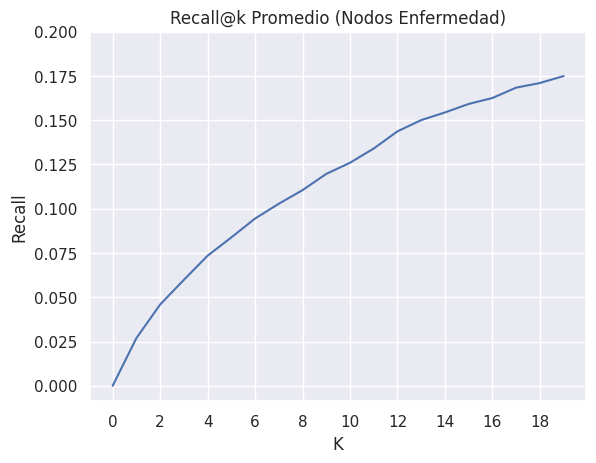

In [30]:
plt.plot([*range(20)],disease_recall_k_2.mean().values)
plt.xticks([0,2,4,6,8,10,12,14,16,18])
plt.ylim(top=0.2)
plt.title("Recall@k Promedio (Nodos Enfermedad)")
plt.xlabel("K")
plt.ylabel("Recall")

In [31]:
disease_precision_results.mean()

precision_10      0.036431
precision_50      0.015898
precision_100     0.010516
precision_300     0.005199
precision_500     0.003681
precision_1000    0.002536
precision_1500    0.002206
precision_1700    0.002138
dtype: float64

Tendría que separarlas en casos:

-Tiene otras asociaciones GDA

-No tienen asociaciones GDA en train-val, tiene asoc. DD en train-val

-No tienen asociaciones GDA en train-val, no tiene asoc. DD

Tiene features *

## New disease
No tiene enlaces GDA en train-val

In [121]:
disease_rank_info

num_positive_labels  first_positive_rank  num_propagation_edges  \
19599                   10                  142                     44   
20754                   82                    1                    801   
24165                   56                    0                    560   
18773                  104                    0                    970   
18732                   13                    2                    127   
...                    ...                  ...                    ...   
28264                    1                16180                      0   
29186                    1                14463                      0   
30663                    1                12868                      0   
21876                    1                 4758                      0   
27465                    1                 7286                      0   

                                               node_name  degree_gda  \
19599                                       Hepatomegaly        54.0   
20754                                      Schizophrenia       883.0   
24165                     Malignant neoplasm of prostate       616.0   
18773                       Malignant neoplasm of breast      1074.0   
18732                                   Bladder Neoplasm       140.0   
...                                                  ...         ...   
28264  HIGH DENSITY LIPOPROTEIN CHOLESTEROL LEVEL QUA...         1.0   
29186      Patella aplasia, coxa vara, tarsal synostosis         1.0   
30663  NEUROPATHY, HEREDITARY SENSORY AND AUTONOMIC, ...         1.0   
21876                                      Porokeratosis         1.0   
27465  Nephropathy with Pretibial Epidermolysis Bullo...         1.0   

       degree_dd  degree_dd_prop  
19599        0.0             0.0  
20754        1.0             1.0  
24165        6.0             6.0  
18773        7.0             7.0  
18732        5.0             5.0  
...          ...             ...  
28264        0.0             0.0  
29186        0.0             0.0  
30663        1.0             0.0  
21876        6.0             6.0  
27465        0.0             0.0  

[2959 rows x 7 columns]

Las enf que quedaron sin enlaces de ningun tipo y sin features tiene sentido que el modelo no pueda decir nada

In [27]:
new_diseases = disease_rank_info[(disease_rank_info.num_propagation_edges == 0)&(disease_rank_info.degree_dd_prop != 0)].index.values
new_diseases_nofeat = disease_rank_info[(disease_rank_info.num_propagation_edges == 0) & (disease_rank_info.degree_dd == 0)].index.values
gda_prop_diseases = disease_rank_info[disease_rank_info.num_propagation_edges != 0].index.values

In [65]:
disease_rank_info.loc[new_diseases_nofeat]

num_positive_labels  first_positive_rank  num_propagation_edges  \
27300                    1                16487                      0   
30987                    1                  130                      0   
28924                    1                14557                      0   
26896                    1                 7042                      0   
23054                    1                 7042                      0   
...                    ...                  ...                    ...   
21472                    1                 1175                      0   
28264                    1                16180                      0   
29186                    1                14463                      0   
30663                    1                12868                      0   
27465                    1                 7286                      0   

                                               node_name  degree_gda  \
27300          Sick Sinus Syndrome 2, Autosomal Dominant         1.0   
30987                  ATRIAL FIBRILLATION, FAMILIAL, 12         1.0   
28924  Hypospadias, Hypertelorism, Upper Lid Coloboma...         1.0   
26896  Alpha-Aminoadipic Semialdehyde Deficiency Disease         1.0   
23054                                    Hyperlysinemias         1.0   
...                                                  ...         ...   
21472                        Alkaline phosphatase raised         1.0   
28264  HIGH DENSITY LIPOPROTEIN CHOLESTEROL LEVEL QUA...         1.0   
29186      Patella aplasia, coxa vara, tarsal synostosis         1.0   
30663  NEUROPATHY, HEREDITARY SENSORY AND AUTONOMIC, ...         1.0   
27465  Nephropathy with Pretibial Epidermolysis Bullo...         1.0   

       degree_dd  degree_dd_prop  
27300        0.0             0.0  
30987        1.0             0.0  
28924        0.0             0.0  
26896        0.0             0.0  
23054        0.0             0.0  
...          ...             ...  
21472        0.0             0.0  
28264        0.0             0.0  
29186        0.0             0.0  
30663        1.0             0.0  
27465        0.0             0.0  

[231 rows x 7 columns]

In [64]:
len(new_diseases_nofeat)

231

In [58]:
disease_attributes = pd.read_csv("../../../data/processed/graph_data_nohubs/nohub_disease_attributes.csv")
disease_no_desc = disease_attributes[(disease_attributes.mondo_definition.isna())&(disease_attributes.umls_description.isna())&(disease_attributes.orphanet_definition.isna())].node_index.values
disease_no_desc_index = list(set(disease_no_desc)&set(new_diseases))
len(disease_no_desc_index)

37

# Esto habría que dividirlo por casos

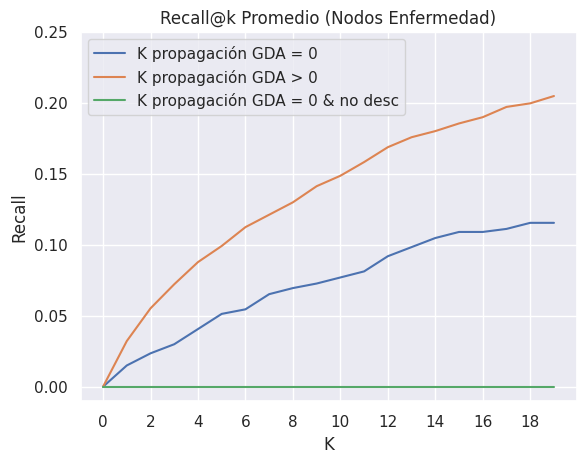

In [32]:
plt.plot([*range(20)],disease_recall_k_2.loc[new_diseases].mean().values, label="K propagación GDA = 0")
plt.plot([*range(20)],disease_recall_k_2.loc[gda_prop_diseases].mean().values, label="K propagación GDA > 0")
plt.plot([*range(20)],disease_recall_k_2.loc[new_diseases_nofeat].mean().values, label="K propagación GDA = 0 & no desc")
plt.xticks([0,2,4,6,8,10,12,14,16,18])
plt.ylim(top=0.25)
plt.title("Recall@k Promedio (Nodos Enfermedad)")
plt.xlabel("K")
plt.ylabel("Recall")
plt.legend()

In [139]:
disease_auc_results.loc[new_diseases].replace({-2:0, -1:1}).mean()

auc_10      0.046830
auc_50      0.126630
auc_100     0.179313
auc_300     0.284964
auc_500     0.335691
auc_1000    0.399516
auc_1500    0.433724
auc_1700    0.443409
auc_full    0.747016
dtype: float64

In [134]:
disease_auc_results.loc[gda_prop_diseases].replace({-2:0, -1:1}).mean()

auc_10      0.167251
auc_50      0.306819
auc_100     0.381140
auc_300     0.521310
auc_500     0.589551
auc_1000    0.673393
auc_1500    0.716103
auc_1700    0.728577
auc_full    0.878513
dtype: float64

In [140]:
disease_recall_k.loc[new_diseases].mean()

0     0.000000
1     0.014957
2     0.023504
3     0.029915
4     0.040598
5     0.051282
6     0.055556
7     0.066239
8     0.070513
9     0.072650
10    0.076923
11    0.081197
12    0.091880
13    0.098291
14    0.104701
15    0.108974
16    0.108974
17    0.111111
18    0.115385
19    0.115385
dtype: float64

In [136]:
disease_recall_k.loc[gda_prop_diseases].mean()

0     0.000000
1     0.091150
2     0.126991
3     0.148230
4     0.169469
5     0.184956
6     0.204867
7     0.217257
8     0.229646
9     0.243805
10    0.255752
11    0.268584
12    0.280531
13    0.290708
14    0.295575
15    0.301770
16    0.307522
17    0.316814
18    0.320354
19    0.329204
dtype: float64

Estaba separando en casos la eval

## Analizando "novel diseases"

Es posible que algunas de estas sean "one shots" en el sentido de que el único enlace que tenían fue a parar a test. En otras palabras, el modelo no vió nunca un enlace de esta enfermedad y ahora le estamos pidiendo que haga predicciones. En estos casos habría que tener esa consideración ...

Dentro de estas hay como "dos niveles" de one shotting, el peor escenario es que esa enfermedad tenía grado 1, y ese único enlace el modelo nunca lo vió, osea que el nodo quedó desconectado del grafo en todo momento, nunca tuvo propagación! (ni en train ni val ni test, nunca!). La otra es que el modelo tenía un solo enlace GDA y quedó en test, pero tenía enlaces dd que pudo usar para propagar. 

Este último caso es lo que llaman "leave one out" en la bibliografía!

Hay que dividirlo en bins según grado total, o según grado msg passing por ahi

Cuantas son "one shots"

In [12]:
gda_prop_df = pd.DataFrame(mapped_df[mapped_df.edge_type == "message_passing"].disease.value_counts()).rename(columns={"disease":"gda_propagation_degree"})
gda_prop_df = pd.merge(gda_prop_df, disease_total_ap_scores, left_index=True,right_index=True,how="right").fillna(0)
oneshots_index = gda_prop_df[(gda_prop_df.num_labels > 0) & (gda_prop_df.gda_propagation_degree == 0)].index.values
rest_index = gda_prop_df[(gda_prop_df.num_labels > 0) & (gda_prop_df.gda_propagation_degree != 0)].index.values

In [13]:
oneshot_df = disease_total_ap_scores.loc[oneshots_index]
print(f"{len(oneshot_df)} enfermedades son \'one shot\' en test. Esto es {round((len(oneshot_df)*100)/2959)}% de los nodos en test")
oneshot_df = oneshot_df.sort_values(by="first_positive_rank")
oneshot_df["reciprocal_rank"] = 1/(oneshot_df["first_positive_rank"] +1)
oneshot_df[:20]

699 enfermedades son 'one shot' en test. Esto es 24% de los nodos en test


num_labels  first_positive_rank  ap_at_10  ap_at_50  ap_at_100  \
31669         1.0                  0.0  1.000000  1.000000   1.000000   
31316         1.0                  0.0  1.000000  1.000000   1.000000   
29347         1.0                  0.0  1.000000  1.000000   1.000000   
30777         1.0                  0.0  1.000000  1.000000   1.000000   
31523         1.0                  0.0  1.000000  1.000000   1.000000   
25941         1.0                  0.0  1.000000  1.000000   1.000000   
33935         1.0                  0.0  1.000000  1.000000   1.000000   
31126         1.0                  1.0  0.500000  0.500000   0.500000   
23830         1.0                  1.0  0.500000  0.500000   0.500000   
33128         1.0                  1.0  0.500000  0.500000   0.500000   
26413         1.0                  1.0  0.500000  0.500000   0.500000   
32284         1.0                  2.0  0.333333  0.333333   0.333333   
32292         1.0                  2.0  0.333333  0.333333   0.333333   
29218         1.0                  2.0  0.333333  0.333333   0.333333   
30021         1.0                  3.0  0.250000  0.250000   0.250000   
31427         1.0                  3.0  0.250000  0.250000   0.250000   
31513         1.0                  3.0  0.250000  0.250000   0.250000   
30975         1.0                  3.0  0.250000  0.250000   0.250000   
22685         1.0                  3.0  0.250000  0.250000   0.250000   
30059         1.0                  4.0  0.200000  0.200000   0.200000   

       recall_at_10  recall_at_50  recall_at_100  total_auc  total_ap  \
31669           1.0           1.0            1.0   1.000000  0.000571   
31316           1.0           1.0            1.0   1.000000  0.000703   
29347           1.0           1.0            1.0   1.000000  0.000167   
30777           1.0           1.0            1.0   1.000000  0.000321   
31523           1.0           1.0            1.0   1.000000  0.000977   
25941           1.0           1.0            1.0   1.000000  0.000297   
33935           1.0           1.0            1.0   1.000000  0.000659   
31126           1.0           1.0            1.0   0.999944  0.000527   
23830           1.0           1.0            1.0   0.999944  0.001541   
33128           1.0           1.0            1.0   0.999944  0.000207   
26413           1.0           1.0            1.0   0.999944  0.001570   
32284           1.0           1.0            1.0   0.999887  0.000109   
32292           1.0           1.0            1.0   0.999887  0.000368   
29218           1.0           1.0            1.0   0.999887  0.000631   
30021           1.0           1.0            1.0   0.999831  0.003597   
31427           1.0           1.0            1.0   0.999831  0.000566   
31513           1.0           1.0            1.0   0.999831  0.001305   
30975           1.0           1.0            1.0   0.999831  0.000109   
22685           1.0           1.0            1.0   0.999831  0.000103   
30059           1.0           1.0            1.0   0.999775  0.000776   

                                               node_name  degree_gda  \
31669                     Oculocutaneous albinism type 6         1.0   
31316  Atrial Septal Defect with Atrioventricular Con...         1.0   
29347                  BRACHYDACTYLY, TYPE B2 (disorder)         1.0   
30777            LIPODYSTROPHY, FAMILIAL PARTIAL, TYPE 4         1.0   
31523     PEROXISOME BIOGENESIS DISORDER 12A (ZELLWEGER)         1.0   
25941                          Pituitary Dwarfism Type 3         1.0   
33935  MUSCULAR DYSTROPHY, LIMB-GIRDLE, AUTOSOMAL DOM...         1.0   
31126                EPILEPSY, FAMILIAL TEMPORAL LOBE, 5         1.0   
23830                      Hypoparathyroidism - X-linked         1.0   
33128                                JOUBERT SYNDROME 27         1.0   
26413            Congenital absence of parathyroid gland         1.0   
32284                                   HYPOTRICHOSIS 12         1.0   
322

Osea, el MRR daría bajo pero.. que a una enfermedad que no vio nunca, le ponga su único enlace en el puesto 10 ENTRE 16000 en realidad está muy bien!! (para mi . . .) como muestro esto??

Creo que había una métrica donde podía ir sumando las cosas que aparecieron. La cuestión es que.. una métrica que me da 0.5 cuando puse en el puesto 2 a un nodo entre 16mil........................... NOSE SI ES MUY REPRESENTATIVA 

Acá estoy queriendo ver si está correlacionada la buena performance con el grado disease-disease, no me salió

In [77]:
fig_df = oneshot_df.copy()
fig_df["has_dd_edges"] = fig_df.degree_dd > 0
fig = px.violin(fig_df, x="has_dd_edges", y="first_positive_rank")
fig.show()

In [21]:
oneshot_df[(oneshot_df.num_labels != 0) & (oneshot_df.degree_dd != 0)].describe().round(3)[["ap_at_10","ap_at_100","recall_at_10","recall_at_100","total_auc","total_ap"]]

ap_at_10  ap_at_100  recall_at_10  recall_at_100  total_auc  total_ap
count   504.000    504.000       504.000        504.000    504.000   504.000
mean      0.028      0.034         0.073          0.254      0.741     0.000
std       0.132      0.131         0.261          0.436      0.295     0.001
min      -0.000     -0.000         0.000          0.000      0.024     0.000
25%      -0.000     -0.000         0.000          0.000      0.475     0.000
50%      -0.000     -0.000         0.000          0.000      0.915     0.000
75%       0.000      0.011         0.000          1.000      0.994     0.000
max       1.000      1.000         1.000          1.000      1.000     0.010

### Viendo un ejemplo particular de una enfermedad "one shot en test" que tuvo buena performance

"Diamond-blackfan anemia 13" es "one shot en test" y logró rankear a su único enlace GDA en el puesto 3 de ~16000. Me llamó la atención porque es una de esas enfermedades "Enfermedad N" que aparecen en DisGeNET. Esta enfermedad tiene grado dd 1, para entender un poco su entorno voy a mirar la comunidad infomap a la que pertenece. Elegí ver la infomap porque es más chica y me interesa el entorno más cercano.

In [19]:
diamond_bf_index = 32292
diamond_bf_comu = node_df.loc[diamond_bf_index,"comunidades_infomap"]
node_df[node_df.comunidades_infomap == diamond_bf_comu]

node_id  \
node_index                                                      
30422                                                C2931850   
26126                                                C1260899   
1731                                              11639_10493   
32840                                                C4225411   
32851                                                C4225422   
2828        14394_13217_32668_12529_32669_44309_12937_1321...   
29647                                                C2675512   
33803                                                C4693556   
29646                                                C2675511   
32292                                                C4014641   
29688                                                C2676137   
33329                                                C4479424   
33330                                                C4479428   
22698                                                C0265265   
31527                                                C3554042   
31956                                                C3809888   
28322                                                C1853666   
29988                                                C2750080   
29673                                                C2675859   
20653                                                C0034902   
28567                                                C1857719   
29989                                                C2750081   
29674                                                C2675860   

                                                    node_name node_type  \
node_index                                                                
30422                                   Aase Smith syndrome 2   disease   
26126                                Anemia, Diamond-Blackfan   disease   
1731        Diamond-Blackfan anemia with mandibulofacial d...   disease   
32840       DIAMOND-BLACKFAN ANEMIA 15 WITH MANDIBULOFACIA...   disease   
32851       DIAMOND-BLACKFAN ANEMIA 14 WITH MANDIBULOFACIA...   disease   
2828                                  Diamond-Blackfan anemia   disease   
29647                               Diamond-Blackfan Anemia 7   disease   
33803                            DIAMOND-BLACKFAN ANEMIA-LIKE   disease   
29646                               Diamond-Blackfan Anemia 8   disease   
32292                              DIAMOND-BLACKFAN ANEMIA 13   disease   
29688                               Diamond-Blackfan Anemia 1   disease   
33329                              DIAMOND-BLACKFAN ANEMIA 16   disease   
33330                              DIAMOND-BLACKFAN ANEMIA 17   disease   
22698                                           Aase syndrome   disease   
31527                              DIAMOND-BLACKFAN ANEMIA 11   disease   
31956                              DIAMOND-BLACKFAN ANEMIA 12   disease   
28322                             Anemia, Diamond-Blackfan, 2   disease   
29988                              Diamond-Blackfan Anemia 10   disease   
29673                               Diamond-Blackfan Anemia 5   disease   
20653                                   Pure Red-Cell Aplasia   disease   
28567                             Anemia, Diamond-Blackfan, 3   disease   
29989                               Diamond-Blackfan Anemia 9   disease   
29674                               Diamond-Blackfan Anemia 4   disease   

           node_source  tensor_index  comunidades_infomap  \
node_index                                                  
30422         disgenet          2673                816.0   
26126         disgenet          2674                816.0   
1731           primekg          3386                816.0   
32840         disgenet          3387                816.0   
32851         disgenet          3388                816.0   
2828           primekg          3389                816.0   
29647         disgenet          6039                816.0   
338

Se ve clarito que es una comunidad que agrupa a varios tipos de "diamond-blackfan anemia", con dos grupos bert (te das cuenta porque la fuente no es disgenet sino primekg) que las conectan.

se me ocurrió una forma de validar, que es usar los datos de la parte minada de Disgenet. Esto sirve?

Estoy viendo si las enfermedades de esa comunidad iban todas al mismo gen y por eso fue "fácil" predecirlo, pero veo que son como 30 distintos.

In [20]:
comu_index = node_df[node_df.comunidades_infomap == 816].index
disease_idx = disgenet_edges.set_index("disease").index
len(disgenet_edges.set_index("disease").loc[comu_index.intersection(disease_idx)].gene_protein.unique())

30

Tendría que ver las "diamond black fan N", que tienen grado 1, si no van al mismo:

In [21]:
comu_index = node_df[(node_df.comunidades_infomap == 816)&(node_df.degree_gda == 1)].index
disease_idx = disgenet_edges.set_index("disease").index
len(disgenet_edges.set_index("disease").loc[comu_index.intersection(disease_idx)].gene_protein.unique())

15

No es el mismo gen y, de hecho, me parece que en general las enfermedades que en disgenet se llaman "Enfermedad N" y hay muchas "N", son enfermedades que tienen una presentación clínica parecida pero están asociadas a genes diferentes (interesante). Por ahí le propuso esos 30 genes que tienen asociadas sus compañeras de comunidad y a uno de esos le pegó. Pero bueno, justamente así funciona la GNN.

In [22]:
comu_index = node_df[(node_df.comunidades_infomap == 816)].index
disease_idx = disgenet_edges.set_index("disease").index
diamond_bf_edge = disgenet_edges.set_index("disease").loc[diamond_bf_index].gene_protein
node_df.loc[disgenet_edges.set_index("gene_protein").loc[diamond_bf_edge].disease.values]

node_id                   node_name node_type node_source  \
node_index                                                               
32292       C4014641  DIAMOND-BLACKFAN ANEMIA 13   disease    disgenet   
32866       C4228778   Abnormality of radial ray   disease    disgenet   
30422       C2931850       Aase Smith syndrome 2   disease    disgenet   
26126       C1260899    Anemia, Diamond-Blackfan   disease    disgenet   

            tensor_index  comunidades_infomap  comunidades_louvain  \
node_index                                                           
32292               6042                816.0                 12.0   
32866               8307                  NaN                  NaN   
30422               2673                816.0                 12.0   
26126               2674                816.0                 12.0   

            degree_gda  degree_pp  degree_dd  total_degree  
node_index                                                  
32292              1.0        0.0        1.0           2.0  
32866             33.0        0.0        0.0          33.0  
30422             15.0        0.0        1.0          16.0  
26126             30.0        0.0        1.0          31.0

Ahí se ve que en la comunidad había otras enfermedades con enlaces a ese mismo gen. Igual, tenian 33, 15 y 30 enlaces diferentes. El modelo ubicó el único que tenia esta enfermedad en el puesto 3!. Puede ser que esté priorizando los enlaces que tienen enfermedades cercanas (y esto estaría bien), pero por ahí también hay más info codificada porque tenía 30 genes para elegir si tomamos solo la comunidad infomap.

Hay otro nivel más de "one shot" que es que no tenga el enlace dd que está en el dataset, porque en el split no apareció. Esto lo podemos saber mirando el dataset de enlaces d-d:

In [27]:
mapped_dd_df.set_index("disease_target").loc[diamond_bf_index]

disease_source                           2828
torch_disease_index_source               3389
torch_disease_index_target               6042
label                                     NaN
edge_type                     message_passing
Name: 32292, dtype: object

Esto es el mismo gráfico de más arriba pero corregido por el tema de que los enlaces dd también entran en el split. Igual da muy parecido, la idea es la misma.

In [35]:
fig_df[fig_df.has_dd_edges == True].describe()

num_labels  first_positive_rank    ap_at_10    ap_at_50   ap_at_100  \
count  468.000000           468.000000  468.000000  468.000000  468.000000   
mean     1.025641          4443.856838    0.029672    0.034989    0.036010   
std      0.171230          5202.409690    0.136215    0.136068    0.135857   
min      1.000000             0.000000   -0.000000   -0.000000   -0.000000   
25%      1.000000            83.000000   -0.000000   -0.000000   -0.000000   
50%      1.000000          1113.500000   -0.000000   -0.000000   -0.000000   
75%      1.000000          9040.000000    0.000000    0.000000    0.011905   
max      3.000000         17310.000000    1.000000    1.000000    1.000000   

       recall_at_10  recall_at_50  recall_at_100  degree_gda   degree_dd  \
count    468.000000    468.000000     468.000000  468.000000  468.000000   
mean       0.076923      0.190171       0.260684    1.025641    1.408120   
std        0.266755      0.392856       0.439477    0.171230    1.171621   
min        0.000000      0.000000       0.000000    1.000000    1.000000   
25%        0.000000      0.000000       0.000000    1.000000    1.000000   
50%        0.000000      0.000000       0.000000    1.000000    1.000000   
75%        0.000000      0.000000       1.000000    1.000000    1.000000   
max        1.000000      1.000000       1.000000    3.000000   13.000000   

       reciprocal_rank  dd_propagation_degree  
count       468.000000             468.000000  
mean          0.037048               1.341880  
std           0.135520               1.027772  
min           0.000058               1.000000  
25%           0.000111               1.000000  
50%           0.000897               1.000000  
75%           0.011905               1.000000  
max           1.000000              11.000000

In [30]:
dd_prop_df = pd.DataFrame(mapped_dd_df[mapped_dd_df.edge_type == "message_passing"].disease_source.value_counts()).rename(columns={"disease_source":"dd_propagation_degree"})

fig_df = oneshot_df.copy()
fig_df = fig_df.merge(dd_prop_df,left_index=True,right_index=True, how="left").fillna(0)
fig_df["has_dd_edges"] = fig_df.dd_propagation_degree > 0
fig = px.violin(fig_df, x="has_dd_edges", y="first_positive_rank")
fig.show()

## Analizando el resto

In [14]:
def group_by_range(data_df,group_column,ranges,inplace=True):
    if not inplace:
        df = data_df.copy()
        bins = np.digitize(df[group_column].values, ranges)
        df["bins"] = bins
        return df
    else:
        df = data_df
        bins = np.digitize(df[group_column].values, ranges)
        df["bins"] = bins

Si filtro las que tenían al menos N de propagación

In [16]:
over_K_prop = gda_prop_df[(gda_prop_df.gda_propagation_degree >= 10)&(gda_prop_df.num_labels > 0)].sort_values(by="first_positive_rank")
over_K_prop.describe()

gda_propagation_degree   num_labels  first_positive_rank     ap_at_10  \
count             1094.000000  1094.000000          1094.000000  1094.000000   
mean                50.372943     5.658135           684.316271     0.188896   
std                 76.252937     8.604141          2284.085869     0.326736   
min                 10.000000     1.000000             0.000000    -0.000000   
25%                 15.000000     2.000000             3.000000     0.000000   
50%                 26.000000     3.000000            30.500000    -0.000000   
75%                 55.750000     6.000000           158.000000     0.250000   
max                970.000000   104.000000         17243.000000     1.000000   

          ap_at_50    ap_at_100  recall_at_10  recall_at_50  recall_at_100  \
count  1094.000000  1094.000000   1094.000000   1094.000000    1094.000000   
mean      0.166021     0.150337      0.348263      0.574040       0.679159   
std       0.267615     0.243099      0.476638      0.494714       0.467013   
min      -0.000000    -0.000000      0.000000      0.000000       0.000000   
25%       0.000000     0.000000      0.000000      0.000000       0.000000   
50%       0.035483     0.033853      0.000000      1.000000       1.000000   
75%       0.200000     0.166667      1.000000      1.000000       1.000000   
max       1.000000     1.000000      1.000000      1.000000       1.000000   

         total_auc     total_ap   degree_gda    degree_dd  
count  1094.000000  1094.000000  1094.000000  1094.000000  
mean      0.887256     0.002871    56.031079     2.651737  
std       0.174097     0.004291    84.556596     5.689778  
min       0.027577     0.000056    11.000000     0.000000  
25%       0.845296     0.000437    17.000000     0.000000  
50%       0.978583     0.001259    29.000000     1.000000  
75%       0.994944     0.003270    61.000000     3.000000  
max       1.000000     0.033531  1074.000000    66.000000

In [3]:
(2284*100)/16000

14.275

In [18]:
rest_df = disease_total_ap_scores.loc[rest_index].sort_values(by="first_positive_rank")
rest_df

num_labels  first_positive_rank  ap_at_10  ap_at_50  ap_at_100  \
24097         2.0                  0.0  1.000000  1.000000   1.000000   
19272         1.0                  0.0  1.000000  1.000000   1.000000   
20522         7.0                  0.0  0.642857  0.395604   0.395604   
19742        12.0                  0.0  1.000000  0.413876   0.271159   
32593         1.0                  0.0  1.000000  1.000000   1.000000   
...           ...                  ...       ...       ...        ...   
20117         1.0              16731.0 -0.000000 -0.000000  -0.000000   
31349         1.0              16871.0 -0.000000 -0.000000  -0.000000   
26637         1.0              17243.0 -0.000000 -0.000000  -0.000000   
29149         1.0              17432.0 -0.000000 -0.000000  -0.000000   
19481         1.0              17541.0 -0.000000 -0.000000  -0.000000   

       recall_at_10  recall_at_50  recall_at_100  \
24097           1.0           1.0            1.0   
19272           1.0           1.0            1.0   
20522           1.0           1.0            1.0   
19742           1.0           1.0            1.0   
32593           1.0           1.0            1.0   
...             ...           ...            ...   
20117           0.0           0.0            0.0   
31349           0.0           0.0            0.0   
26637           0.0           0.0            0.0   
29149           0.0           0.0            0.0   
19481           0.0           0.0            0.0   

                                  node_name  degree_gda  degree_dd  
24097   Other specified cardiac arrhythmias        11.0        1.0  
19272                    Myoclonic Epilepsy         9.0        5.0  
20522                       Lobar Pneumonia        54.0        0.0  
19742           Profound Mental Retardation       139.0        0.0  
32593                     C3 glomerulopathy         9.0        1.0  
...                                     ...         ...        ...  
20117        Mitral Valve Prolapse Syndrome         3.0        3.0  
31349      Triple Negative Breast Neoplasms         4.0        1.0  
26637      Pancreatic Ductal Adenocarcinoma        11.0        3.0  
29149  Pseudoxanthoma Elasticum, Incomplete         3.0        0.0  
19481                                  Gout         9.0        1.0  

[2260 rows x 11 columns]

In [133]:
aver = group_by_range(rest_df,"first_positive_rank",np.logspace(0,5),False)
fig = px.histogram(aver, "bins")
fig.show()

In [161]:
rest_df

num_labels  first_positive_rank  ap_at_10  ap_at_50  ap_at_100  \
24097         2.0                  0.0  1.000000  1.000000   1.000000   
19272         1.0                  0.0  1.000000  1.000000   1.000000   
20522         7.0                  0.0  0.642857  0.395604   0.395604   
19742        12.0                  0.0  1.000000  0.413876   0.271159   
32593         1.0                  0.0  1.000000  1.000000   1.000000   
...           ...                  ...       ...       ...        ...   
20117         1.0              16731.0 -0.000000 -0.000000  -0.000000   
31349         1.0              16871.0 -0.000000 -0.000000  -0.000000   
26637         1.0              17243.0 -0.000000 -0.000000  -0.000000   
29149         1.0              17432.0 -0.000000 -0.000000  -0.000000   
19481         1.0              17541.0 -0.000000 -0.000000  -0.000000   

       precision_at_10  precision_at_50  precision_at_100  \
24097              0.1             0.02              0.01   
19272              0.1             0.02              0.01   
20522              0.2             0.08              0.04   
19742              0.1             0.06              0.05   
32593              0.1             0.02              0.01   
...                ...              ...               ...   
20117              0.0             0.00              0.00   
31349              0.0             0.00              0.00   
26637              0.0             0.00              0.00   
29149              0.0             0.00              0.00   
19481              0.0             0.00              0.00   

                                  node_name  degree_gda  degree_dd  
24097   Other specified cardiac arrhythmias        11.0        1.0  
19272                    Myoclonic Epilepsy         9.0        5.0  
20522                       Lobar Pneumonia        54.0        0.0  
19742           Profound Mental Retardation       139.0        0.0  
32593                     C3 glomerulopathy         9.0        1.0  
...                                     ...         ...        ...  
20117        Mitral Valve Prolapse Syndrome         3.0        3.0  
31349      Triple Negative Breast Neoplasms         4.0        1.0  
26637      Pancreatic Ductal Adenocarcinoma        11.0        3.0  
29149  Pseudoxanthoma Elasticum, Incomplete         3.0        0.0  
19481                                  Gout         9.0        1.0  

[2260 rows x 11 columns]

In [169]:
rest_df[rest_df.num_labels > 50].ap_at_100.mean()

0.5334211511494492

# Modo 2

Calcular AP solo con los rankings que me generan los enlaces que quedaron en test, osea, la misma muestra sobre la que evalué AUC, en lugar de todas las combinaciones posibles.

In [145]:
pred = predictor.predict_supervision_edges(test_data,("gene_protein","gda","disease"))

disease_index = []
ap_at_10 = []
ap_at_5 = []
k = []

for disease in pred.torch_disease_index.unique():
    labels = pred[pred.torch_disease_index == disease].sort_values(by="score", ascending=False)["label"].values
    scores = pred[pred.torch_disease_index == disease].sort_values(by="score", ascending=False)["score"].values
    k.append(len(labels))

    if len(labels) >= 10:
        labels = labels[:10]
        scores = scores[:10]
        ap_at_10.append(average_precision_score(labels,scores))  
    else:
        ap_at_10.append(average_precision_score(labels,scores))
    
    if len(labels) >= 5:
        labels = labels[:5]
        scores = scores[:5]
        ap_at_5.append(average_precision_score(labels,scores))
    else:
        ap_at_5.append(average_precision_score(labels,scores))

    disease_index.append(disease)

ap_df = pd.DataFrame({"disease_index":disease_index,"ap_at_10":ap_at_10,"ap_at_5":ap_at_5, "k":k})
ap_df

/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:877: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:877: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:877: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:877: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:877: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/home/ingrid/Do

disease_index  ap_at_10  ap_at_5    k
0              1614  1.000000     1.00    6
1                20  0.884354     0.95   16
2              1363  1.000000     1.00    2
3                 3  1.000000     1.00  146
4               916  1.000000     1.00    1
...             ...       ...      ...  ...
5262           3755 -0.000000    -0.00    1
5263           2654 -0.000000    -0.00    1
5264           4584 -0.000000    -0.00    1
5265           2558 -0.000000    -0.00    1
5266           9181 -0.000000    -0.00    1

[5267 rows x 4 columns]

In [146]:
ap_df[ap_df.k < 5]

disease_index  ap_at_10  ap_at_5  k
2              1363       1.0      1.0  2
4               916       1.0      1.0  1
7               522       1.0      1.0  4
8              6331       1.0      1.0  4
14             8080       1.0      1.0  4
...             ...       ...      ... ..
5262           3755      -0.0     -0.0  1
5263           2654      -0.0     -0.0  1
5264           4584      -0.0     -0.0  1
5265           2558      -0.0     -0.0  1
5266           9181      -0.0     -0.0  1

[4507 rows x 4 columns]

Estos son los "one shot"

In [155]:
ap_df[ap_df.k == 1].ap_at_5.mean().round(2)

0.36

El resto

In [170]:
ap_df[ap_df.k >= 5].ap_at_5.mean().round(2)

0.91

In [148]:
ap_df[ap_df.k >= 10].ap_at_10.mean().round(2)

0.92

In [149]:
ap_df[(ap_df.k <= 10)&(ap_df.k >= 5)].ap_at_5.mean().round(2)

0.89

In [150]:
ap_df[(ap_df.k <= 10)&(ap_df.k >= 5)]

disease_index  ap_at_10   ap_at_5   k
0              1614  1.000000  1.000000   6
19              895  0.754592  0.679167  10
25             1249  1.000000  1.000000   6
26             1894  0.975000  1.000000  10
31             1377  0.915079  0.950000   8
...             ...       ...       ...  ..
3362          10502 -0.000000 -0.000000   5
3408           1908 -0.000000 -0.000000   5
3432           7709 -0.000000 -0.000000   5
3870           5688 -0.000000 -0.000000   5
4089           6091 -0.000000 -0.000000   5

[464 rows x 4 columns]

Esto está balanceado?

In [14]:
pred = predictor.predict_supervision_edges(test_data,("gene_protein","gda","disease"),False)
labels = test_data.edge_label_dict[("gene_protein","gda","disease")]
average_precision_score(labels,pred)

0.9063889136629331

In [253]:
pred

torch_gene_protein_index  torch_disease_index     score  label
0                          6951                 1614  0.909069    1.0
1                          7772                   20  0.873451    1.0
2                           599                 1363  0.663127    1.0
3                         10254                    3  0.587420    1.0
4                          2986                  916  0.980938    1.0
...                         ...                  ...       ...    ...
16797                      6817                  672  0.008400    0.0
16798                      1224                  352  0.001227    0.0
16799                     14330                  903  0.817325    0.0
16800                     13487                 2014  0.000022    0.0
16801                      7433                 3882  0.317744    0.0

[16802 rows x 4 columns]

In [271]:
pred[["torch_disease_index","label"]].value_counts()

torch_disease_index  label
3                    1.0      104
1                    1.0       82
48                   1.0       68
379                  1.0       67
36                   1.0       64
                             ... 
4742                 0.0        1
4740                 0.0        1
4732                 0.0        1
4722                 0.0        1
13991                0.0        1
Length: 7032, dtype: int64

In [255]:
pred_balance = pd.DataFrame(index=pred.torch_disease_index.unique())
pred_balance["num_samples"] = pred.torch_disease_index.value_counts()
pred_balance["num_positive"] 

num_samples
1614            6
20             16
1363            2
3             146
916             1
...           ...
3755            1
2654            1
4584            1
2558            1
9181            1

[5267 rows x 1 columns]

# Hits

In [179]:
predictions = predictor.prioritize_one_vs_all(16899)

In [180]:
predictions

[tensor([34065, 32276, 33350,  ..., 21850, 21436, 24257]),
 tensor([1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 2.8140e-19, 2.7781e-19,
         3.1687e-21])]

In [184]:
new_edges[new_edges["disease"] == 16899]

Empty DataFrame
Columns: [gene_protein, disease]
Index: []

In [187]:
def hits_at_k(node_index,seen_edges_df,new_edges_df):
    k_list = [5,10,50,100]
    predictions = predictor.prioritize_one_vs_all(node_index)

    node_type = node_df.loc[node_index,"node_type"]
    y_type = "disease" if node_type == "gene_protein" else "gene_protein"

    node_new_edges = set(new_edges_df[new_edges_df[node_type] == node_index][y_type].values)
    node_seen_edges = set(seen_edges_df[seen_edges_df[node_type] == node_index][y_type].values)

    results = {"seen_edges":len(node_seen_edges),"new_edges":len(node_new_edges)}

    for k in k_list:
        predicted_top = set(predictions[0][:k].numpy())

        seen_hits = len(node_seen_edges&predicted_top)
        new_hits = len(node_new_edges&predicted_top)

        results[f"{k}_seen"] = seen_hits
        results[f"{k}_new"] = new_hits

    return results

TODO: pasar esto al script de prediction utils

In [188]:
disease_evals = {}
for disease in tqdm(node_df[node_df.node_type == "disease"].index.values):
    predictions = predictor.prioritize_one_vs_all(disease)
    disease_evals[disease] = hits_at_k(disease,seen_edges,new_edges)

100%|██████████| 16079/16079 [01:04<00:00, 248.61it/s]


In [191]:
gene_evals = {}
for gene_protein in tqdm(node_df[node_df.node_type == "gene_protein"].index.values):
    predictions = predictor.prioritize_one_vs_all(gene_protein)
    gene_evals[gene_protein] = hits_at_k(gene_protein,seen_edges,new_edges)

100%|██████████| 17743/17743 [01:02<00:00, 282.48it/s]


In [192]:
df = node_df

total_disease_evals = pd.DataFrame(disease_evals).T
cols = total_disease_evals.columns
total_disease_evals = total_disease_evals.merge(df["node_name"],left_index=True,right_index=True)[["node_name",*cols]]

total_gene_evals = pd.DataFrame(gene_evals).T
cols = total_gene_evals.columns
total_gene_evals = total_gene_evals.merge(df["node_name"],left_index=True,right_index=True)[["node_name",*cols]]

k_list = [5,10,50,100]
summary_disease_evals = pd.DataFrame()
for k in k_list:
    summary_disease_evals[f"hits_{k}"] = total_disease_evals[f"{k}_new"] + total_disease_evals[f"{k}_seen"]

cols = summary_disease_evals.columns
add_cols=["node_name","degree_gda","degree_dd","comunidades_infomap","comunidades_louvain"]
summary_disease_evals = pd.merge(summary_disease_evals,df[add_cols],left_index=True,right_index=True)[[*add_cols,*cols]]

summary_gene_evals = pd.DataFrame()
for k in k_list:
    summary_gene_evals[f"hits_{k}"] = total_gene_evals[f"{k}_new"] + total_gene_evals[f"{k}_seen"]

cols = summary_gene_evals.columns
add_cols = ["node_name","degree_gda","degree_pp"]
summary_gene_evals = pd.merge(summary_gene_evals,df[add_cols],left_index=True,right_index=True)[[*add_cols,*cols]]

total_disease_evals = total_disease_evals.merge(summary_disease_evals["degree_gda"],left_index=True,right_index=True)
total_gene_evals = total_gene_evals.merge(summary_gene_evals["degree_gda"],left_index=True,right_index=True)

In [196]:
def save_hits_df(model_name,desc,disease_total,disease_summary,gene_total,gene_summary,reports_folder=reports_folder+"ranking_analysis/hits"):
    disease_total.to_csv(reports_folder+model_name+"_total_disease.csv")
    disease_summary.to_csv(reports_folder+model_name+"_summary_disease.csv")
    gene_summary.to_csv(reports_folder+model_name+"_summary_gene.csv")
    gene_total.to_csv(reports_folder+model_name+"_total_gene.csv")

    with open(reports_folder+model_name+"_desc.txt", "w") as f:
        f.write(desc)

def load_hits_df(model_name,reports_folder=reports_folder+"ranking_analysis/hits"):
    fnames = ["_total_disease.csv","_summary_disease.csv","_summary_gene.csv","_total_gene.csv"]
    dfs = []
    for fname in fnames:
        dfs.append(pd.read_csv(reports_folder+model_name+fname,index_col=0))
    return dfs

def group_by_range(data_df,group_column,ranges,inplace=True):
    if not inplace:
        df = data_df.copy()
        bins = np.digitize(df[group_column].values, ranges)
        df["bins"] = bins
        return df
    else:
        df = data_df
        bins = np.digitize(df[group_column].values, ranges)
        df["bins"] = bins

def plot_box(data_df,value_cols,title,range_text,y_top):
    melted_df = data_df[["bins",*value_cols]].melt("bins").rename(columns={"value":"hits"})
    melted_df["Nivel de Evidencia"] = melted_df.bins.apply(lambda x: range_text[x])
    fig = px.box(melted_df.sort_values(by="bins"),y="hits",x="Nivel de Evidencia",color="variable",title=title,width=900,height=450,labels={"hits":"Hits"})
    fig.update_yaxes(range=[-0.5, y_top])
    fig.show()

In [194]:
model_name = f"sage_lsa"
desc = "final_model"

save_hits_df(model_name,desc,total_disease_evals,summary_disease_evals,total_gene_evals,summary_gene_evals)

In [201]:
# model_name = "sage_ones_no_sampling"
# model_name = "sage_ones_first_negatives_exp_04_07_23__12_07"
model_name = "sage_lsa"
hits_df = load_hits_df(model_name)

disease_ranges = np.array([10,50,100,hits_df[0].degree_gda.max()+1]).astype(int)
gene_ranges = np.array([5,20,50,100,hits_df[3].degree_gda.max()+1]).astype(int)
range_text = ["< 10","10-50","50-100","100 +"]

for i,data in enumerate(hits_df):
    if i<2:
        data = group_by_range(data[data.degree_gda != 0],"degree_gda",disease_ranges,inplace=False)
        hits_df[i] = data
    else:
        data = group_by_range(data[data.degree_gda != 0],"degree_gda",gene_ranges,inplace=False)
        hits_df[i] = data       

value_pairs = [["5_seen","5_new"],["10_seen","10_new"],["50_seen","50_new"]]
for pair in value_pairs:
    plot_box(hits_df[0],pair,"Evaluación Enfermedades",range_text,51)

# One fold con M muestras

En vez de comparar vs todos los nodos posibles, generar muestras de M nodos y hacer ahí el ranking

In [189]:
positive_sup_edges = mapped_df[mapped_df.label == 1][["gene_protein","disease"]]

## MRR y hits @ k para enfermedades y genes

In [109]:
test_size = len(positive_sup_edges)
M = 500
k_values = [5,20,30]
hits_list = [0,0,0]
reciprocal_ranks = []

for edge in positive_sup_edges.values:
    gene, disease = edge

    #saco los enlaces que ya vio
    to_remove = seen_edges[seen_edges.disease == disease].gene_protein.values
    targets = node_df[node_df.node_type == "gene_protein"].drop(to_remove).index.values
    target_sample = np.append(np.random.choice(targets,M), gene)
    ranked_index, ranked_scores = predictor.prioritize_one_vs_all(disease,target_sample)
    
    rank = np.where(ranked_index == gene)[0][0] +1

    # hits@k
    for i,k in enumerate(k_values):
        if rank <= k:
            hits_list[i] += 1
    #MRR
    reciprocal_ranks.append(1/rank)

hits_k_results = np.array(hits_list)/test_size
mean_reciprocal_rank = np.sum(reciprocal_ranks)/test_size

print(hits_k_results, mean_reciprocal_rank)


[0.44423283 0.63801928 0.67563385] 0.3192508488016502


In [114]:
test_size = len(positive_sup_edges)
M = 500
k_values = [5,20,30]
hits_list = [0,0,0]
reciprocal_ranks = []

for edge in positive_sup_edges.values:
    gene, disease = edge

    #saco los enlaces que ya vio
    to_remove = seen_edges[seen_edges.gene_protein == gene].disease.values
    targets = node_df[node_df.node_type == "disease"].drop(to_remove).index.values
    target_sample = np.append(np.random.choice(targets,M), disease)
    ranked_index, ranked_scores = predictor.prioritize_one_vs_all(gene,target_sample)
    
    rank = np.where(ranked_index == disease)[0][0] +1

    # hits@k
    for i,k in enumerate(k_values):
        if rank <= k:
            hits_list[i] += 1
    #MRR
    reciprocal_ranks.append(1/rank)

hits_k_results = np.array(hits_list)/test_size
mean_reciprocal_rank = np.sum(reciprocal_ranks)/test_size

print(hits_k_results, mean_reciprocal_rank)

[0.41578384 0.61326033 0.66861088] 0.31632365307824345


## Lo mismo pero quiero ver quien es cada uno

In [205]:
test_size = len(positive_sup_edges)
M = 500
k_values = [5,20,30]
hits_list = [[],[],[]]
reciprocal_ranks = []

for edge in positive_sup_edges.values:
    gene, disease = edge

    #saco los enlaces que ya vio
    to_remove = seen_edges[seen_edges.disease == disease].gene_protein.values
    targets = node_df[node_df.node_type == "gene_protein"].drop(to_remove).index.values
    target_sample = np.append(np.random.choice(targets,M), gene)
    ranked_index, ranked_scores = predictor.prioritize_one_vs_all(disease,target_sample)
    
    rank = np.where(ranked_index == gene)[0][0] +1

    # hits@k
    for i,k in enumerate(k_values):
        if rank <= k:
            hits_list[i].append(1)
        else:
            np.array(hits_list).T
            hits_list[i].append(0)
    #MRR
    reciprocal_ranks.append(1/rank)

# hits_k_results = np.array(hits_list)/test_size
# mean_reciprocal_rank = np.sum(reciprocal_ranks)/test_size

# print(hits_k_results, mean_reciprocal_rank)

/tmp/ipykernel_16110/2484414807.py:23: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/tmp/ipykernel_16110/2484414807.py:23: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/tmp/ipykernel_16110/2484414807.py:23: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/tmp/ipykernel_16110/2484414807.py:23: VisibleDeprecationWarning:

Creating an 

In [206]:
d_rank_eval_results = pd.DataFrame(np.array(hits_list).T, columns=["hits_5","hits_20","hits_30"])
d_rank_eval_results["reciprocal_rank"] = reciprocal_ranks
d_rank_eval_results["disease_node_index"] = positive_sup_edges.disease.values
d_rank_eval_results

hits_5  hits_20  hits_30  reciprocal_rank  disease_node_index
0          1        1        1         0.250000               28433
1          1        1        1         0.250000               21061
2          0        1        1         0.062500               19538
3          0        0        0         0.003040               18773
4          1        1        1         1.000000               28696
...      ...      ...      ...              ...                 ...
8396       0        1        1         0.058824               19702
8397       1        1        1         0.250000               25003
8398       0        1        1         0.125000               21217
8399       0        1        1         0.111111               26819
8400       1        1        1         0.200000               33257

[8401 rows x 5 columns]

In [171]:
d_rank_eval_mean = d_rank_eval_results.groupby(["disease_node_index"]).mean()
d_rank_eval_mean["count"] = d_rank_eval_results.groupby(["disease_node_index"]).count()["hits_5"]
d_rank_eval_mean

hits_5   hits_20   hits_30  reciprocal_rank  count
disease_node_index                                                      
18432               0.000000  0.000000  0.000000         0.003774      1
18434               0.000000  0.000000  0.000000         0.009970      2
18435               0.333333  0.777778  0.777778         0.174169      9
18438               0.333333  0.500000  0.500000         0.242165     12
18446               0.000000  0.000000  0.000000         0.007463      1
...                      ...       ...       ...              ...    ...
34158               0.000000  0.000000  0.000000         0.010101      1
34160               0.000000  0.000000  0.000000         0.003401      1
34164               0.000000  0.000000  0.000000         0.002105      1
34169               0.000000  0.000000  0.000000         0.006494      1
34195               0.000000  0.000000  0.000000         0.002212      1

[2959 rows x 5 columns]

In [172]:
d_rank_eval_mean = d_rank_eval_mean.merge(node_df[["degree_gda","degree_dd"]],left_on="disease_node_index", right_index=True,how="left")
d_rank_eval_mean.sort_values(by="count",ascending=False)

hits_5   hits_20   hits_30  reciprocal_rank  count  \
disease_node_index                                                         
18773               0.192308  0.230769  0.250000         0.167883    104   
20754               0.085366  0.134146  0.134146         0.064830     82   
19957               0.000000  0.014706  0.014706         0.006070     68   
18978               0.029851  0.089552  0.089552         0.039496     67   
20574               0.218750  0.453125  0.484375         0.205724     64   
...                      ...       ...       ...              ...    ...   
23771               0.000000  1.000000  1.000000         0.071429      1   
23769               1.000000  1.000000  1.000000         1.000000      1   
23767               0.000000  0.000000  1.000000         0.047619      1   
23765               0.000000  0.000000  0.000000         0.003125      1   
34195               0.000000  0.000000  0.000000         0.002212      1   

                    degree_gda  degree_dd  
disease_node_index                         
18773                   1074.0        7.0  
20754                    883.0        1.0  
19957                    774.0        0.0  
18978                    702.0        5.0  
20574                    616.0        5.0  
...                        ...        ...  
23771                      5.0        2.0  
23769                      1.0        1.0  
23767                     17.0        2.0  
23765                      5.0        2.0  
34195                      7.0        1.0  

[2959 rows x 7 columns]

In [179]:
d_rank_eval_mean.sort_values(by="count",ascending=False)[100:110]

hits_5   hits_20   hits_30  reciprocal_rank  count  \
disease_node_index                                                         
25966               0.461538  0.846154  0.846154         0.260690     13   
21432               0.750000  1.000000  1.000000         0.684921     12   
19742               0.416667  0.750000  0.750000         0.298751     12   
26075               0.583333  0.750000  0.833333         0.353120     12   
20905               1.000000  1.000000  1.000000         0.727778     12   
22472               0.250000  0.416667  0.583333         0.199108     12   
24466               1.000000  1.000000  1.000000         0.805556     12   
20177               0.666667  0.916667  1.000000         0.467617     12   
18816               0.250000  0.583333  0.666667         0.105599     12   
33376               0.916667  1.000000  1.000000         0.697222     12   

                    degree_gda  degree_dd  
disease_node_index                         
25966                    139.0        0.0  
21432                    101.0        0.0  
19742                    139.0        0.0  
26075                    137.0        5.0  
20905                    115.0        0.0  
22472                    105.0        0.0  
24466                    101.0        0.0  
20177                    125.0        1.0  
18816                    159.0        7.0  
33376                    101.0        0.0